# Statical Learning. Final Project. Phase 1
### Golnoosh Abdollahinejad

In [1]:
#lib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as RForest#

### A) Read Data

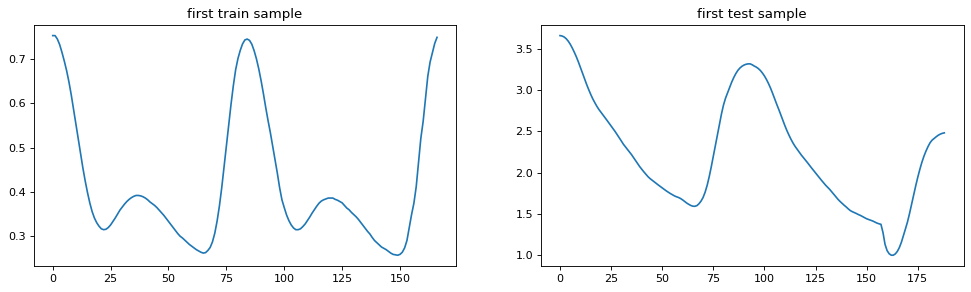

In [2]:
# read data sets from paths
train_path = '/content/drive/MyDrive/SL-prj/s1_train.npy'
test_path = '/content/drive/MyDrive/SL-prj/s1_test.npy'
# training data
data_train = np.load(train_path, allow_pickle=True)
# test data
data_test = np.load(test_path, allow_pickle=True)

#plot one sample for each
plt.figure(figsize=(15,4), dpi=80)
plt.subplot(1, 2, 1)
plt.plot(data_train[0][0])
plt.title('first train sample')
plt.subplot(1, 2, 2)
plt.plot(data_test[0][0])
plt.title('first test sample')
plt.show()

Automatic Multiscale-based Peak Detection (AMPD) is a peak detector, which will be used in preprocessing of PPG samples

ampdLib implements automatic multiscale-based peak detection (AMPD) algorithm as in An Efficient Algorithm for Automatic Peak Detection in Noisy Periodic and Quasi-Periodic Signals, by Felix Scholkmann, Jens Boss and Martin Wolf, Algorithms 2012, 5, 588-603.

https://github.com/LucaCerina/ampdLib

In [3]:
# AMPD function
def ampd(sigInput, LSMlimit = 1): 
    """Find the peaks in the signal with the AMPD algorithm.
    
        Original implementation by Felix Scholkmann et al. in
        "An Efficient Algorithm for Automatic Peak Detection in 
        Noisy Periodic and Quasi-Periodic Signals", Algorithms 2012,
            5, 588-603

        Parameters
        ----------
        sigInput: ndarray
            The 1D signal given as input to the algorithm
        lsmLimit: float
            Wavelet transform limit as a ratio of full signal length.
            Valid values: 0-1, the LSM array will no longer be calculated after this point
                which results in the inability to find peaks at a scale larger than this factor.
                For example a value of .5 will be unable to find peaks that are of period 
                1/2 * signal length, a default value of 1 will search all LSM sizes.

        Returns
        -------
        pks: ndarray
            The ordered array of peaks found in sigInput
    """ 
    # Create preprocessing linear fit	
    sigTime = np.arange(0, len(sigInput))
    
    # Detrend
    dtrSignal = (sigInput - np.polyval(np.polyfit(sigTime, sigInput, 1), sigTime)).astype(float)
    
    N = len(dtrSignal)
    L = int(np.ceil(N*LSMlimit / 2.0)) - 1
    
    # Generate random matrix
    LSM = np.ones([L,N], dtype='uint8')
    
    # Local minima extraction
    for k in range(1, L):
        LSM[k - 1, np.where((dtrSignal[k:N - k - 1] > dtrSignal[0: N - 2 * k - 1]) & (dtrSignal[k:N - k - 1] > dtrSignal[2 * k: N - 1]))[0]+k] = 0
    
    pks = np.where(np.sum(LSM[0:np.argmin(np.sum(LSM, 1)), :], 0)==0)[0]
    return pks

PPG samples are not equal-length, so they need preprocessing.

My preprocessing has 3 parts to align peaks of signals in one point and add zeros for empty left and right parts

Part 1: for every sample, position of peaks are detected and find max length of right and left side for signals' peak.

Besides, we want model to learn predicting BP value from PPG samples with 2 peaks. If any sample has less peak, it will be omitted it from train set and update number of samples.


In [4]:

def preprocess1(N, data, target, testset_mode=False):
    peak = np.zeros((N,1))
    print(peak.shape)
    max_peak_left = 0
    #le_max = 0
    max_peak_right = 0
    #le_min = 200
    nonvalid = []
    for i in range(N):
        signal = data[i]
        j = signal.shape[0]
        #X[i,:j] = signal
        #print(i)
        all_peak = ampd(signal)
        p = all_peak[ signal[all_peak] > max(signal[15:-15]) * 0.75]
        if p.shape[0] != 1:
            if p.shape[0] % 2 == 1:
                peak[i,:] = p[int(np.floor(p.shape[0]/2))]
                #find
                if max_peak_left < peak[i,:] :
                    max_peak_left = peak[i,:]
                if max_peak_right < len(signal) - peak[i,:] :
                    max_peak_right = len(signal) - peak[i,:]

            #print('floor', p[int(np.floor(p.shape[0]/2))])
            else:
                print('sample', i, ' is nonvalid data with no peak, deleted from dataset')
                plt.plot(signal)
                plt.plot(p, signal[p], 'ro')
                plt.show()
                #peak[i,:] = max(signal)
                #save nonvalid indices
                nonvalid.append(i)
        else:
            peak[i,:] = p
            #find
            if max_peak_left < peak[i,:] :
                max_peak_left = peak[i,:]
            if max_peak_right < len(signal) - peak[i,:] :
                max_peak_right = len(signal) - peak[i,:]

        #worst peak location
    print('worst (max) left  length of peak', max_peak_left)
    print('worst (max) right length of peak', max_peak_right)
    y = target    
    #delete nonvalid data with no peak
    X_list = np.delete(data, nonvalid, axis=0)
    y = np.delete(y, nonvalid, axis=None)
    peak = np.delete(peak, nonvalid, axis=None)
    #
    print('number of samples', X_list.shape[0])
    print(N - X_list.shape[0], ' samples deleted')
    N = X_list.shape[0]
    if testset_mode:
        return N, X_list, peak, max_peak_left, max_peak_right
    return N, X_list, y, peak, max_peak_left, max_peak_right

Part 2 uses max right and left lenght to define fix length samples and place each PPG sample in the right place due to its peak. Finally for train set, shuffles samples and BP targets.

In [5]:
def preprocess2(Nsamples, X_list, target, peak, max_peak_left, max_peak_right, testset_mode=False):
    #find max lenght of samples to build X array
    #with center peaks in (midle/same) position
    sample_max_length = int(max(199, max_peak_left + max_peak_right))
    print('samples max length', sample_max_length)
    peak_loc = int(max_peak_left)
    print('place all peaks at location', peak_loc)
    # 
    X = np.zeros((Nsamples,sample_max_length))
    # place ...
    for i in range(Nsamples):
        signal = X_list[i]
        j = signal.shape[0]
        p = peak[i]
        #print(int(118-p),int(118-p+j), j)
        X[i, int(118-p):int(118-p+j)] = signal

    print('shape of samples', X.shape)
    
    if testset_mode:
        return X
    
    X, y = shuffle(X, target, random_state=42)
    return X, y

(1000, 1)
sample 685  is nonvalid data with no peak, deleted from dataset


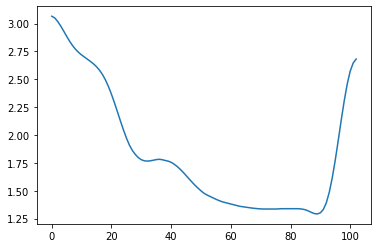

sample 980  is nonvalid data with no peak, deleted from dataset


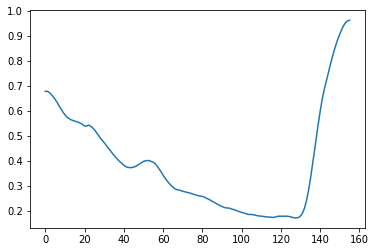

worst (max) left  length of peak [118.]
worst (max) right length of peak [117.]
number of samples 998
2  samples deleted


In [6]:
#part 1 of preprocessing for train set
Nsamples = 1000
Nsamples, X_list, y, peak, max_peak_left, max_peak_right = preprocess1(Nsamples,
                                                                      data_train[:,0],
                                                                      data_train[:,1] )

In [7]:
# new number of train samples
print(Nsamples)

998


the same pre process for test samples

In [8]:
#part 1 of preprocessing for test set
Ntest = 100 #number of test samples
Ntest, X_list_test, peak_test, max_peak_left_test, max_peak_right_test = preprocess1(Ntest,
                                                                    data_test[:,0],
                                                                    None, testset_mode=True)

(100, 1)
worst (max) left  length of peak [100.]
worst (max) right length of peak [99.]
number of samples 100
0  samples deleted


to have the same frame for both test and train samples use max length for each left and right side

In [9]:
max_peak_left = max([max_peak_left, max_peak_left_test])
max_peak_right = max([max_peak_right, max_peak_right_test])
print('max peak left' , max_peak_left, 'max_peak_right', max_peak_right)

max peak left [118.] max_peak_right [117.]


In [10]:
#part 2 of preprocessing for train set
X, y = preprocess2(Nsamples, X_list, y, peak, max_peak_left, max_peak_right)

samples max length 235
place all peaks at location 118
shape of samples (998, 235)


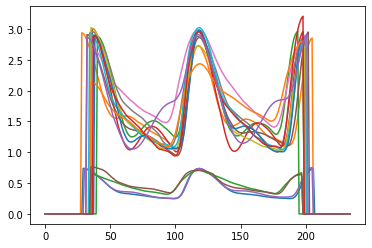

In [11]:
#plot some PPG samples after preprocessing
#aligned-peaks sample will help part 3 of preprocessing
for i in range(0,Nsamples,65):
    plt.plot(X[i])
plt.show()

In [12]:
#part 2 of preprocessing for test set
X_test = preprocess2(Ntest, X_list_test, None, peak_test, max_peak_left, max_peak_right, testset_mode=True)

samples max length 235
place all peaks at location 118
shape of samples (100, 235)


The last part of preprocessing using PCA for dimention reduction but to prevent test part of data in cross validation, it comes right before using each model and after splitting train and test samples at each iteration.

In [13]:
def preprocess3(X_train, X_test, pca_comp):
    st = StandardScaler()
    pca = PCA(n_components=pca_comp)
    #normalize
    X_train = st.fit_transform(X_train)# no usage of test data
    X_test = st.transform(X_test)# X_test is calculated due to X_train
    #dimention reduction
    X_train = pca.fit_transform(X_train)# no usage of test data
    X_test = pca.transform(X_test)# X_test is calculated due to X_train
    return X_train, X_test

## B) Base-line model: 

mean of BP values

In [14]:
# base_line model
BL_y = np.mean(y)
BL_rss_train = np.sum((y - BL_y)**2)
print('total sum of squers fot base-line model', BL_rss_train)
acc_base = 1 - np.sqrt(np.mean(((y - BL_y)/y)**2))
print('base-line model accuracy', acc_base*100, '%')

total sum of squers fot base-line model 659915.8404682868
base-line model accuracy 78.85180930745676 %


In [15]:
BL_y

131.0568536615196

### C) Main model

using cross validation to find best model with least test error.

each model has tow function: 

1. main function (with lower case) to train based on train data and find total sum of squers for train and test.

2. and the other function (with upper case) to preform inner section of nested cross validation. 

Simple linear Regression which has no hyper parameter

In [16]:
def LR_simple(x_train, y_train, x_test, y_test):
    mode = LinearRegression()
    mode.fit(x_train, y_train)
    yp = mode.predict(x_test)
    rss_test = ((yp - y_test) ** 2).sum()
    #print((yp - y_test).T)
    yp = mode.predict(x_train)
    rss_train = ((yp - y_train) ** 2).sum()
    #print(rss_train/900, rss_test/100)
    return rss_train, rss_test

Lasso linear regression

In [17]:
def lasso(X_train, y_train, X_test, y_test, L):
    st = StandardScaler()
    X_train = st.fit_transform(X_train)
    X_test = st.transform(X_test)
    mode = Lasso(alpha=L, normalize=False, max_iter = 10000)
    mode.fit(X_train, y_train)
    yp = mode.predict(X_test)
    rss_test = ((yp - y_test) ** 2).sum()
    yp = mode.predict(X_train)
    rss_train = ((yp - y_train) ** 2).sum()
    return rss_train, rss_test

In [18]:
def LR_Lasso(X_train, y_train, X_test, y_test, alphaL):
    CV = []
    for l in alphaL:
        #inner CV to choose best hyperP for each iteration of outter iterations of nested CV
        cv = Kfold_CV(X_train, y_train, model = lasso, HyperP=l)
        CV.append(cv)
    L_index = np.argmin(np.array(CV)) 
    selected_L = alphaL[L_index]
    print('Selected Hyper Parameter', selected_L)#, CV)
    rss_train, rss_test = lasso(X_train, y_train, X_test, y_test, selected_L)
    return rss_train, rss_test

Ridge linear regression

In [19]:
def ridge(X_train, y_train, X_test, y_test, L):
    st = StandardScaler()
    X_train = st.fit_transform(X_train)
    X_test = st.transform(X_test)
    mode = Ridge(alpha=L, normalize=False)
    mode.fit(X_train, y_train)
    yp = mode.predict(X_test)
    rss_test = ((yp - y_test) ** 2).sum()
    yp = mode.predict(X_train)
    rss_train = ((yp - y_train) ** 2).sum()
    return rss_train, rss_test

In [20]:
def LR_Ridge(X_train, y_train, X_test, y_test, alphaL):
    CV = []
    for l in alphaL:
        #inner CV to choose best hyperP for each iteration of outter iterations of nested CV
        cv = Kfold_CV(X_train, y_train, model = ridge, HyperP=l)
        CV.append(cv)
    L_index = np.argmin(np.array(CV)) 
    selected_L = alphaL[L_index]
    print('Selected Hyper Parameter', selected_L)# CV)
    rss_train, rss_test = ridge(X_train, y_train, X_test, y_test, selected_L)
    return rss_train, rss_test

Support Vector Machine regression

In [21]:
def svr(X_train, y_train, X_test, y_test, c, final_model=False):
    mode = SVR(epsilon=0, C=c, max_iter=100000, tol = 1e-5, kernel = 'rbf', gamma=1e-1)
    mode.fit(X_train, y_train)
    yp = mode.predict(X_train)
    acc = 1 - np.sqrt(np.mean(((y_train - yp)/y_train)**2))
    rss_train = ((yp - y_train) ** 2).sum()
    yp = mode.predict(X_test)
    if final_model:
        return rss_train, yp, acc
    #--------------------------------------
    rss_test = ((yp - y_test) ** 2).sum()
    return rss_train, rss_test

In [22]:
def LR_SVR(X_train, y_train, X_test, y_test, alphaL):
    CV = []
    for l in alphaL:
        #inner CV to choose best hyperP for each iteration of outter iterations of nested CV
        cv = Kfold_CV(X_train, y_train, model = svr, HyperP=l)
        CV.append(cv)
    L_index = np.argmin(np.array(CV)) 
    selected_L = alphaL[L_index]
    print('Selected Hyper Parameter', selected_L)#, CV)
    rss_train, rss_test = svr(X_train, y_train, X_test, y_test, selected_L)
    return rss_train, rss_test

Random Forest regression

In [23]:
def forest(X_train, y_train, X_test, y_test, hp, final_model=False):
    #mode = RForest(max_features='auto', n_estimators=n, max_depth=d, n_jobs = -1, random_state=42)
    mode = RForest(n_estimators=hp, random_state=0)
    #----max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto”
    mode.fit(X_train, y_train)
    yp = mode.predict(X_train)
    acc = 1 - np.sqrt(np.mean(((y_train - yp)/y_train)**2))
    rss_train = ((yp - y_train) ** 2).sum()
    yp = mode.predict(X_test)
    if final_model:
        return rss_train, yp, acc
    #--------------------------------------
    rss_test = ((yp - y_test) ** 2).sum()
    return rss_train, rss_test

In [24]:
def RandomForest(X_train, y_train, X_test, y_test, alphaL):
    CV = []
    for l in alphaL:#n_estimators
        #inner CV to choose best hyperP for each iteration of outter iterations of nested CV
        cv = Kfold_CV(X_train, y_train, model = forest, HyperP=l)
        CV.append(cv)
    L_index = np.argmin(np.array(CV)) 
    selected_L = alphaL[L_index]
    print('Selected Hyper Parameter', selected_L)#, CV)
    rss_train, rss_test = forest(X_train, y_train, X_test, y_test, selected_L)
    return rss_train, rss_test

***Adaboost*** and ***smoothing spline*** were also checked but didn't perform good and didn't converge.

### Cross validation Function

In [25]:
def Kfold_CV(X, y, model, HyperP, K=5, pca_comp=50):
    #HyperP is a single value or a list of hyper parameter that will check with CV
    kf = KFold(n_splits=K)
    kf.get_n_splits(X)
    CV = 0
    for train_index, test_index in kf.split(X):
        #split test and train
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        #------------------------------------------------------------------------
        #part 3 of preprocessing: PCA
        X_train, X_test = preprocess3(X_train, X_test, pca_comp)
        #------------------------------------------------------------------------
        if HyperP == None : #models with no hyperparameter 
            rss_train, rss_test = model(X_train, y_train, X_test, y_test)
            #print(CV, rss_train, rss_test)
        else: #models with hyperparameter 
            rss_train, rss_test = model(X_train, y_train, X_test, y_test, HyperP)
        #------------------------------------------------------------------------
        #print(rss_train, rss_test)
        CV += rss_test
    CV = CV / X.shape[0]
    #print(CV)
    #print(len(X), X.shape[0])
    return CV

using nested Cross Validation for model selection.

model with less Cross value will be chosen as best model

In [26]:
#nested Cross Validation for model selection
CV_simple = Kfold_CV(X, y, LR_simple, HyperP=None)
print('LR simple CV', CV_simple, '\n')
HP = [0.001, 0.01, 0.1, 1, 10, 100, 1e3, 1e4]#HyperP
cHP = [0.001, 0.01, 0.1, 1, 10, 100]#hyperP only for SVM
HPrf = [100, 200, 300]#hyperP only for random farest as n_estimators
# becuase of hardware resources can't expand hyper parameter search value or use grid search on multi parameters
CV_min = CV_simple
best_model = "simple"
CV_Ridge = Kfold_CV(X, y, LR_Ridge, HP)
print('Ridge CV', CV_Ridge, '\n')
if CV_min > CV_Ridge:
    CV_min = CV_Ridge
    best_model = "ridge"
CV_Lasso = Kfold_CV(X, y, LR_Lasso, HP)
print('Lasso CV', CV_Lasso, '\n')
if CV_min > CV_Lasso:
    CV_min = CV_Lasso
    best_model = "lasso"
CV_svr = Kfold_CV(X, y, LR_SVR, HyperP=cHP)
print('SVM CV', CV_svr, '\n')
if CV_min > CV_svr:
    CV_min = CV_svr
    best_model = "svr"
CV_RF = Kfold_CV(X, y, RandomForest, HPrf)
print('RandomForest CV', CV_RF, '\n')
if CV_min > CV_RF:
    CV_min = CV_RF
    best_model = "rf"
print('best CV is', CV_min, 'for model', best_model)

LR simple CV 681.914277015944 

Selected Hyper Parameter 10000.0
Selected Hyper Parameter 10000.0
Selected Hyper Parameter 10000.0
Selected Hyper Parameter 10000.0
Selected Hyper Parameter 10000.0
Ridge CV 656.8912467036112 

Selected Hyper Parameter 10
Selected Hyper Parameter 10
Selected Hyper Parameter 10
Selected Hyper Parameter 1
Selected Hyper Parameter 10
Lasso CV 660.8610862313379 

Selected Hyper Parameter 10
Selected Hyper Parameter 10
Selected Hyper Parameter 10
Selected Hyper Parameter 10
Selected Hyper Parameter 10
SVM CV 567.7559460561581 

Selected Hyper Parameter 300
Selected Hyper Parameter 100
Selected Hyper Parameter 200
Selected Hyper Parameter 300
Selected Hyper Parameter 300
RandomForest CV 581.6935010879488 

best CV is 567.7559460561581 for model svr


After selecting best model, using simple cross validation to choose hyper parameter.

In [27]:
if best_model == 'rf':
    HP = [200, 300, 400]
else:
    HP = [1, 10, 100, 1000] #value around selected hyperP from previuos section
CV_min = 1e10
best_HP = 0
for h in HP:
    if best_model == 'lasso':
        CV_ = Kfold_CV(X, y, lasso, h)
        if CV_min > CV_:
            CV_min = CV_
            best_HP = h
        print('hyper parameter', h, 'with CV', CV_)
    if best_model == 'ridge':
        CV_ = Kfold_CV(X, y, ridge, h)
        if CV_min > CV_:
            CV_min = CV_
            best_HP = h
        print('hyper parameter', h, 'with CV', CV_)
    if best_model == 'svr':
        CV_ = Kfold_CV(X, y, svr, h)
        if CV_min > CV_:
            CV_min = CV_
            best_HP = h
        print('hyper parameter', h, 'with CV', CV_)
    if best_model == 'rf':
        CV_ = Kfold_CV(X, y, forest, h)
        if CV_min > CV_:
            CV_min = CV_
            best_HP = h
        print('hyper parameter', h, 'with CV', CV_)
print('best model', best_model, 'with hyper parameter', best_HP, '& CV:', CV_min)

hyper parameter 1 with CV 644.9478735546952
hyper parameter 10 with CV 567.5010755687831
hyper parameter 100 with CV 535.3131550187442
hyper parameter 1000 with CV 558.1000902490197
best model svr with hyper parameter 100 & CV: 535.3131550187442


best number of component for PCA is 49 with CV 534.3287032026204


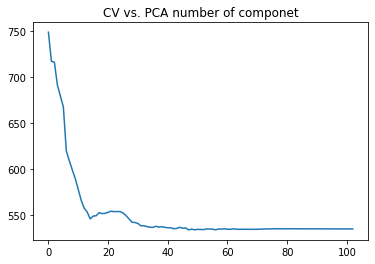

In [28]:
#choose pca number of component as another hyper parameter
CV_min = 800
pcaa = []
for c in range(2,105): #search for 2 to 105 PCA component for best model
        CV_ = Kfold_CV(X, y, svr, best_HP, pca_comp=c)
        if CV_min > CV_:
            CV_min = CV_
            best_pca = c #select pca_comp with less CV
        pcaa.append(CV_)# save CV to plot
        #print(c, CV_)
print('best number of component for PCA is', best_pca, 'with CV', CV_min)
plt.plot(pcaa)
plt.title('CV vs. PCA number of componet')
plt.show()

Finally after selecting best model and all hyper parameters, train model with all train data and predict on PPG test samples.

In [29]:
#part 3 of preprocessing: PCA
X_, X_t = preprocess3(X, X_test, best_pca)
#------------------------------------------------------------------------
if best_model == "simple":
    rss, _ = LR_simple(X_, y, X_t, y)
elif best_model == "ridge":
    rss, _ = ridge(X_, y, X_t, y, best_HP)
elif best_model == "lasso":
    rss, _ = lasso(X_, y, X_t, y, best_HP)
elif best_model == "svr":
    rss, s1_predicted, acc = svr(X_, y, X_t, y, best_HP, final_model=True)
elif best_model == "rf":
    rss, s1_predicted, acc = forest(X_, y, X_t, y, best_HP, final_model=True)

print("model:", best_model, 'with hyper parameter', best_HP)
print('total sum of squers:', rss)
print('accuracy of model on train set:', acc * 100, '%')

model: svr with hyper parameter 100
total sum of squers: 28294.861392820054
accuracy of model on train set: 95.2115078326657 %


In [30]:
print('improvment of total sum of squers:', (1 - rss/BL_rss_train)*100, '%')
print('improvment of accuracy:', (acc/acc_base - 1)*100, '%')

improvment of total sum of squers: 95.71235305205865 %
improvment of accuracy: 20.747397769174402 %


D) s1_predicted 

In [31]:
print(s1_predicted)
np.save('s1_predicted.npy', s1_predicted)

[115.47152641 131.14615934 127.85656746 131.57436181 130.18112405
 130.29027193 129.28089582 148.64591007 133.22311657 152.45661862
 131.17295212 125.52158048 143.18261165 122.18840879 122.61635702
 132.81281443 126.44883761 142.56852367 130.11700641 131.56019024
 131.45582275 131.56740132 126.42008217 141.69195196  99.09316989
 126.44756859 119.5944902  131.33135199 130.57807116 126.72511386
 139.50062697 145.2373754  135.24033931 130.79148553 119.99675455
 169.91352613 119.0233253  148.24555957 131.54826027 131.70022229
 137.75661717 175.21502321 128.82903687 133.06233678 130.96944687
 102.47989493 125.39528738 127.57885105  97.61876042 136.09049616
 155.56177293 135.66267675 109.96371856 142.54682901 140.83832786
 120.35808501 126.22360439 147.15633763 105.27927667 138.17137958
 142.11817213 136.11527142 128.30324783 112.79779425 131.33561806
 146.49870161 129.5497013  117.47833691 105.39063324 150.99516461
  98.27004762 140.40179978 127.91156018 142.38043761 132.49823383
 131.85314